In [1]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path="/content/drive/MyDrive/Thesis/Dataset/Prepare_for_mask_rcnn_without_augmentation/output/train"
images = sorted(os.listdir(file_path + "/image"))
masks = sorted(os.listdir(file_path + "/mask"))

(720, 1280, 3)


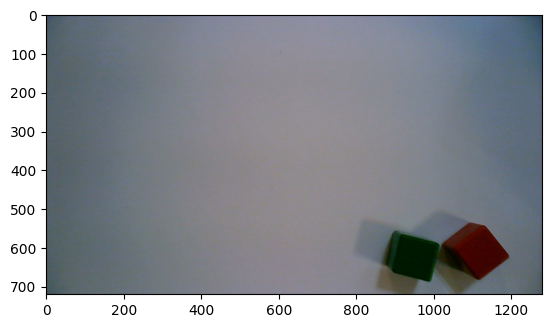

(720, 1280)
(720, 1280, 1)


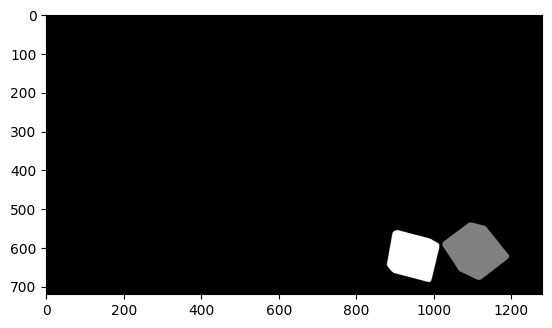

In [4]:
img_dir = file_path + '/image'
mask_dir = file_path + '/mask'
image_id = 76
img = images[image_id]

image = np.array(Image.open(os.path.join(img_dir, img)))
print(image.shape)
plt.imshow(image)
plt.show()

mask_image = np.array(Image.open(os.path.join(mask_dir, os.path.splitext(img)[0] + ".png")).convert('L'))
print(mask_image.shape)
mask_image = np.expand_dims(mask_image, axis=-1)
print(mask_image.shape)
plt.imshow(mask_image, cmap="gray")
plt.show()

In [5]:
mask_image1 = mask_image[:, :, 0]
# for checking unique values in matrix
mask_image1[mask_image1 > 1] = 1
res = list(set(i for j in mask_image1 for i in j))
# printing result
print("Unique values in matrix are : " + str(res))

Unique values in matrix are : [0, 1]


In [6]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.images_name = sorted(os.listdir(self.file_path + "/image"))
        self.masks_name = sorted(os.listdir(self.file_path + "/mask"))

    def __getitem__(self , idx):
        img = Image.open(self.file_path + "/image/" + self.images_name[idx]).convert("RGB")
        mask = Image.open(self.file_path + "/mask/" + self.masks_name[idx]).convert("L")
        mask = np.expand_dims(mask, axis=-1)
        self.imgs = img
        mask = np.array(mask)
        mask = mask[:, :, 0]
        # for checking unique values in matrix
        mask[mask > 1] = 1
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.images_name)

In [7]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [8]:
transform = T.ToTensor()

In [9]:
def custom_collate(data):
  return data

In [10]:
train_dl = torch.utils.data.DataLoader(CustDat("/content/drive/MyDrive/Thesis/Dataset/Prepare_for_mask_rcnn_without_augmentation/output/train") ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat("/content/drive/MyDrive/Thesis/Dataset/Prepare_for_mask_rcnn_without_augmentation/output/val") ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [13]:
params = [p for p in model.parameters() if p.requires_grad]

In [14]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [15]:
num_epoch = 202
all_train_losses = []
all_val_losses = []
flag = False
flag_continue = True
epoch = 0
while epoch < num_epoch:
    train_epoch_loss = 0
    val_epoch_loss = 0
    if flag_continue:
      PATH = f'/content/drive/MyDrive/Thesis/Segmentation/Mask RCNN/Mask-RCNN-finetuning-PyTorch/Training_on_my_dataset_2nd_Try/models/model_180.pth'
      checkpoint = torch.load(PATH)
      model.load_state_dict(checkpoint['model'])
      optimizer.load_state_dict(checkpoint['optimizer'])
      epoch = checkpoint['epoch'] + 1
      all_train_losses = checkpoint['all_train_losses']
      all_val_losses = checkpoint['all_val_losses']
      flag_continue = False
    print(f'epoch: {epoch}/{num_epoch}')
    model.train()
    for i , dt in enumerate(train_dl):
        imgs = []
        targ = []
        for l in range(len(dt)):
          imgs.append(dt[l][0].to(device))
          targ.append(dt[l][1])
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    if epoch%10 == 0:
      PATH = f'/content/drive/MyDrive/Thesis/Segmentation/Mask RCNN/Mask-RCNN-finetuning-PyTorch/Training_on_my_dataset_2nd_Try/models/model_{epoch}.pth'
      torch.save({'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'all_train_losses': all_train_losses,
            'all_val_losses': all_val_losses,
            'epoch': epoch
            }, PATH)
    with torch.no_grad():
        for j , dt2 in enumerate(val_dl):
            imgs = []
            targ = []
            for l in range(len(dt2)):
              imgs.append(dt2[l][0].to(device))
              targ.append(dt2[l][1])
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)
    epoch += 1

epoch: 181/202
{'loss_classifier': tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.0566, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(4.8684e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)}
181    27.221525095403194    10.700427442789078
epoch: 182/202
182    27.24116349965334    10.320454075932503
epoch: 183/202
183    27.056546039879322    10.423817671835423
epoch: 184/202
184    27.071376346051693    10.399102829396725
epoch: 185/202
185    27.83554981276393    13.37863840162754
epoch: 186/202
186    29.14329519495368    10.286892119795084
epoch: 187/202
187    26.9323492012918    10.60520526021719
epoch: 188/202
188    27.416818510740995    10.743247456848621
epoch: 189/202
189    26.897697426378727    10.50178728997

In [16]:
# PATH = f'/content/drive/MyDrive/Thesis/Segmentation/Mask RCNN/Mask-RCNN-finetuning-PyTorch/Training_on_my_dataset_2nd_Try/models/model_101.pth'
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# epoch = checkpoint['epoch'] + 1
# train_epoch_loss = checkpoint['loss']
# model.eval()

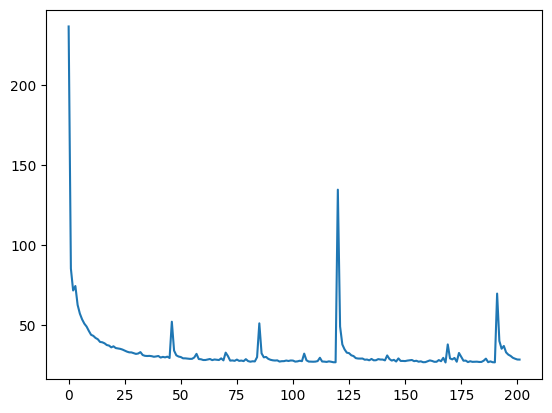

In [17]:
plt.plot(all_train_losses)

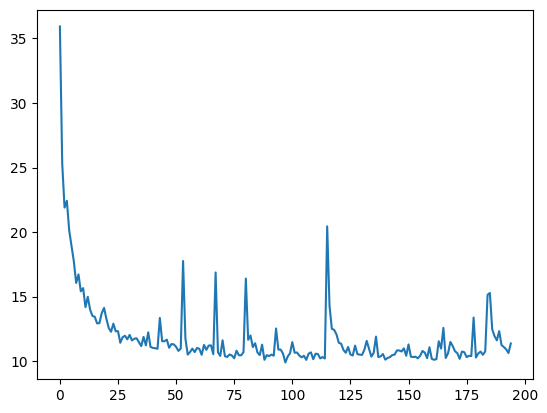

In [18]:
plt.plot(all_val_losses)

In [19]:
!wget https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg

--2023-10-31 08:58:07--  https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206784 (202K) [binary/octet-stream]
Saving to: ‘couple-3687274_960_720.jpg’

couple-3687274_960_ 100%[===================>] 201.94K  --.-KB/s    in 0.01s   

2023-10-31 08:58:08 (15.9 MB/s) - ‘couple-3687274_960_720.jpg’ saved [206784/206784]



In [22]:
test_file_path="/content/drive/MyDrive/Thesis/Dataset/Prepare_for_mask_rcnn_without_augmentation/output/test"
test_images = sorted(os.listdir(test_file_path + "/image"))
test_img_dir = test_file_path + '/image'
test_image_id = 8%len(test_images)
test_img = test_images[test_image_id]

(720, 1280, 3)


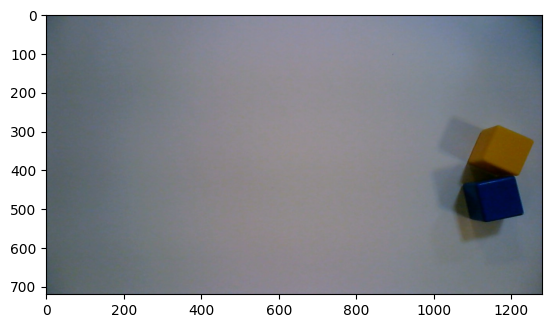

In [23]:
model.eval()
transform = T.ToTensor()
test_image = np.array(Image.open(os.path.join(test_img_dir, test_img)))
print(test_image.shape)
plt.imshow(test_image)
plt.show()
ig = transform(test_image)
with torch.no_grad():
    pred = model([ig.to(device)])

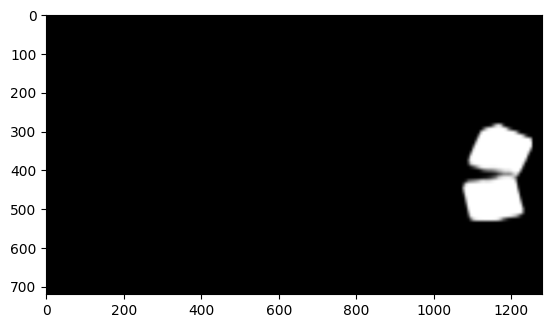

In [24]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze(), cmap='gray')